# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
### IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# # Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/Courses/Semester-1/CS682/HW/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Courses/Semester-1/CS682/HW/assignment1


In [4]:

from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import os
import itertools

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [6]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [7]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [9]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

input_dim = X_train_feats.shape[1]
hidden_dim = 50
num_classes = 10
learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_svm = None
combos = [(v[0], v[1]) for v in list(itertools.product(learning_rates, regularization_strengths))]
best_acc = -1
best_combo = ()

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for combo in combos:
    print('\nEvaluating combo: ', combo)
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=combo[0], reg=combo[1], num_iters=1500,
                        verbose=True)

    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    if best_acc < val_accuracy:
        best_acc = val_accuracy
        best_svm = svm
        best_combo = combo
    results[combo] = (train_accuracy, val_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
print('\n')
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print(f"\nBest accuracy achieved is {best_acc} with learning rate is {best_combo[0]} and regularization strength of {best_combo[1]}")



Evaluating combo:  (1e-09, 50000.0)
iteration 0 / 1500: loss 87.305952
iteration 100 / 1500: loss 85.752290
iteration 200 / 1500: loss 84.248666
iteration 300 / 1500: loss 82.748517
iteration 400 / 1500: loss 81.284914
iteration 500 / 1500: loss 79.832931
iteration 600 / 1500: loss 78.442921
iteration 700 / 1500: loss 77.077975
iteration 800 / 1500: loss 75.725990
iteration 900 / 1500: loss 74.402681
iteration 1000 / 1500: loss 73.102199
iteration 1100 / 1500: loss 71.833412
iteration 1200 / 1500: loss 70.599899
iteration 1300 / 1500: loss 69.365082
iteration 1400 / 1500: loss 68.187090

Evaluating combo:  (1e-09, 500000.0)
iteration 0 / 1500: loss 834.344066
iteration 100 / 1500: loss 684.660583
iteration 200 / 1500: loss 562.135619
iteration 300 / 1500: loss 461.831159
iteration 400 / 1500: loss 379.712937
iteration 500 / 1500: loss 312.478381
iteration 600 / 1500: loss 257.438861
iteration 700 / 1500: loss 212.389163
iteration 800 / 1500: loss 175.504390
iteration 900 / 1500: loss 

In [10]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.413


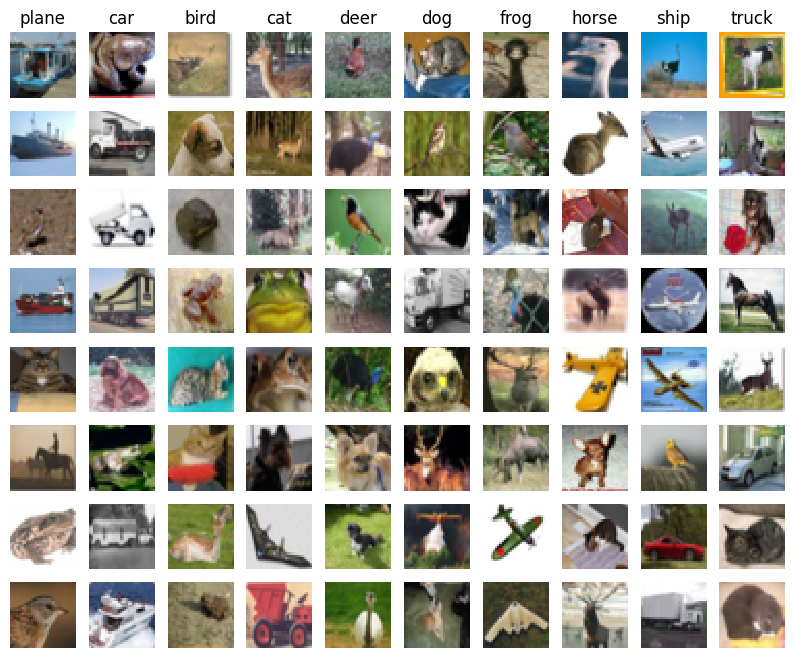

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Answer:**
- There is a pattern in misclassification. It seems to be happening with classes that have similar shapes. For ex, Under plane class, we can see bird, motor boat in the above result. Both bird and motor boat have a similar shape to a plane in some orientations. The classifications of dogs, cats, deer, horse show a similar pattern.
- Other patterns of misclassification can be seen in images with similar backgrounds.
- These misclassifications are likely due to the fact that the use of HOG and color histogram do not provide enough information about the objects and their differences for the model to perform well in differentiating between these objects. Color histogram captures colors, but due to similar colors found between different species of animal this information is not enough. HOG captures structures and textures. This is also enough to differentiate between objects like cat and dog. HOG is also sensitive to scaling, rotation, background change, etc in images.
- However if the HOG and color histogram is used with other feature detection algorithms like SIFT or SURF, it would boost up the performance. SIFT (Scale Invariant Feature Transform) is a feature detection algorithm that is unaffected by scale, illumination, rotation and viewpoint. If used in conjunction with HOG and color histogram, the model will have more information to accurately differentiate between similar objects and yield better results. SURF is partly inspired by SIFT and is a fast and robust algorithm for local, similarity invariant representation and comparison of images.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [24]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code

learning_rates = [ 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
regularization_strengths = [5e-9, 5e-8, 5e-7, 5e-6, 5e-5, 5e-4, 5e-3, 5e-2, 5e-1, 5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
combos = [(v[0], v[1]) for v in list(itertools.product(learning_rates, regularization_strengths))]
best_acc = -1
best_combo = ()
best_stats = {}

# Train the network
for combo in combos:
    print("\nTesting combo: ", combo)
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
        num_iters=2000, batch_size=200,
        learning_rate=combo[0], learning_rate_decay=0.95,
        reg=combo[1], verbose=True)
    if not(np.isnan(stats['loss_history'][-1])):
        acc = (net.predict(X_val_feats) == y_val).mean()
        if (best_acc < acc):
            best_acc = acc
            best_net = net
            best_combo = combo
            best_stats = stats

print(f"\nBest accuracy achieved is {best_acc} with learning rate is {best_combo[0]} and regularization strength of {best_combo[1]}")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


Testing combo:  (1e-10, 5e-09)
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302585
iteration 200 / 2000: loss 2.302585
iteration 300 / 2000: loss 2.302585
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.302585
iteration 600 / 2000: loss 2.302585
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302585
iteration 1000 / 2000: loss 2.302585
iteration 1100 / 2000: loss 2.302585
iteration 1200 / 2000: loss 2.302585
iteration 1300 / 2000: loss 2.302585
iteration 1400 / 2000: loss 2.302585
iteration 1500 / 2000: loss 2.302585
iteration 1600 / 2000: loss 2.302585
iteration 1700 / 2000: loss 2.302585
iteration 1800 / 2000: loss 2.302585
iteration 1900 / 2000: loss 2.302585

Testing combo:  (1e-10, 5e-08)
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302585
iteration 200 / 2000: loss 2.302585
iteration 300 / 2000: loss 2.302585
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.3

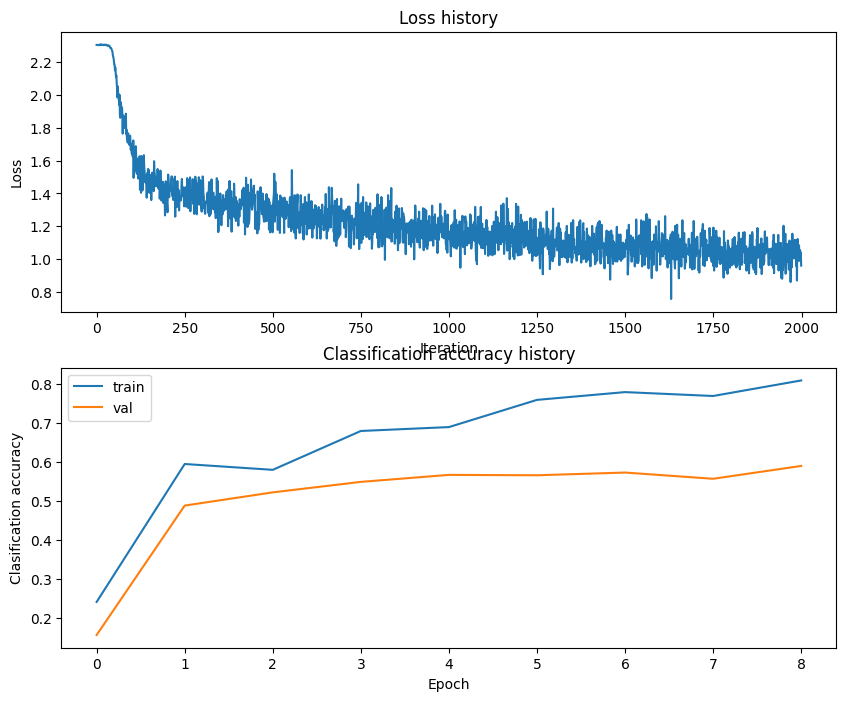

In [33]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [26]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.577
